## Problem: at any given point in a game (given the current score), what is the probability that Player 1 or Player 2 wins?

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, log_loss

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression

In [27]:
tennis_winners = pd.read_pickle('tennis_winners')

In [28]:
tennis_winners.head()

,FixtureId,Competitor1CurrentGameScorePoints,Competitor1CurrentSetScore,Competitor1MatchScore,Competitor2CurrentGameScorePoints,Competitor2CurrentSetScore,Competitor2MatchScore,Serving,Winner,StateOfPlay_BetweenPoints,StateOfPlay_Challenge,StateOfPlay_MedicalTimeoutCompetitorOne,StateOfPlay_MedicalTimeoutCompetitorTwo,StateOfPlay_PlaySuspended,StateOfPlay_PointInProgress,StateOfPlay_ShortDelay,StateOfPlay_WinnerCompetitorOne,StateOfPlay_WinnerCompetitorTwo
0,3221713,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0
1,3221713,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,0
2,3221713,0,0,0,2,0,0,2,0,1,0,0,0,0,0,0,0,0
3,3221713,1,0,0,2,0,0,2,0,1,0,0,0,0,0,0,0,0
4,3221713,1,0,0,3,0,0,2,0,1,0,0,0,0,0,0,0,0


In [100]:
X = tennis_winners.drop(['Winner', 'FixtureId'], axis=1)
y = tennis_winners['Winner'] 

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .3, random_state = 42)

### Pipeline

In [192]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('sfm', SelectFromModel(LogisticRegression(penalty='l1'))),
    ('poly', PolynomialFeatures()),
    ('lr', LogisticRegression())
    ])

In [193]:
params = {
    'poly__degree': [2,3,4],
    'lr__C': np.logspace(-4,4,9)
    }

In [194]:
grid = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
grid.best_score_

In [ ]:
grid.best_estimator_.named_steps['lr']. #whatever I want to see

In [ ]:
grid.score(X_test, y_test)

#### Logistic Regression model

In [102]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# do some polynomial feature engineering - make new features to explore correlations
# use low C and L1 with logreg to reduce features
# PCA

In [163]:
params = {
    'logreg__C': np.logspace(-4,4,9)
}

In [166]:
logreg = GridSearchCV(LogisticRegression(), param_grid=params)

In [167]:
logreg.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [168]:
logreg.best_estimator_

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [169]:
logreg.score(X_train_scaled, y_train)

0.74431852756830641

In [170]:
logreg.score(X_test_scaled, y_test)

0.74478879392731345

In [173]:
log_loss(y_test, logreg.predict_proba(X_test_scaled))

0.51090497008191205

In [172]:
y_test_pred = logreg.predict(X_test_scaled)

In [153]:
confusion = confusion_matrix(y_test, y_test_pred)
pd.DataFrame(confusion, columns=['predicted loss', 'predicted win'], index=['true loss', 'true win'])

,predicted loss,predicted win
true loss,63156,24800
true win,22004,73155


In [154]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.74      0.72      0.73     87956
          1       0.75      0.77      0.76     95159

avg / total       0.74      0.74      0.74    183115



In [155]:
y_test_proba = logreg.predict_proba(X_test_scaled)

In [156]:
y_test_proba[:,1][:3]

array([ 0.24230195,  0.02621543,  0.06046778])

In [157]:
fpr, tpr, thresh = roc_curve(y_test, y_test_proba[:,1])

In [158]:
auc(fpr,tpr)

0.83033728057925493

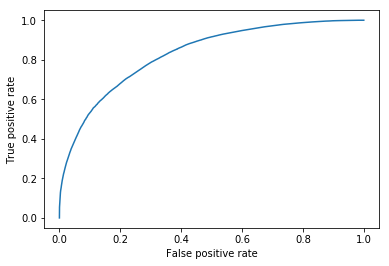

In [159]:
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

/Users/emmafreeman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


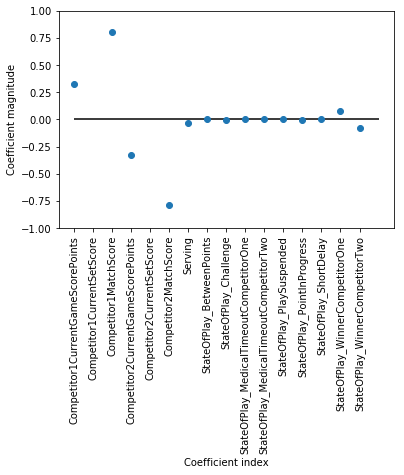

In [161]:
plt.plot(logreg.best_estimator_.coef_.T, 'o')
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.hlines(0, 0, X.shape[1])
plt.ylim(-1, 1)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.legend()

#### Decision Tree model

In [120]:
from sklearn.tree import DecisionTreeClassifier

In [121]:
DTC = DecisionTreeClassifier()

In [122]:
DTC.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [123]:
print("Accuracy on training set: {:.3f}".format(DTC.score(X_train_scaled, y_train))) 
print("Accuracy on test set: {:.3f}".format(DTC.score(X_test_scaled, y_test)))

Accuracy on training set: 0.751
Accuracy on test set: 0.741


In [124]:
print("Feature importances:\n{}".format(DTC.feature_importances_))

Feature importances:
[  3.01357877e-02   1.82349534e-01   2.88417618e-01   3.06413088e-02
   1.50295917e-01   2.96630765e-01   1.87922021e-02   1.28597396e-03
   5.14125762e-05   5.77166054e-09   6.43947917e-06   2.03600192e-06
   7.73393540e-04   1.74225969e-05   4.26499810e-04   1.73684177e-04]


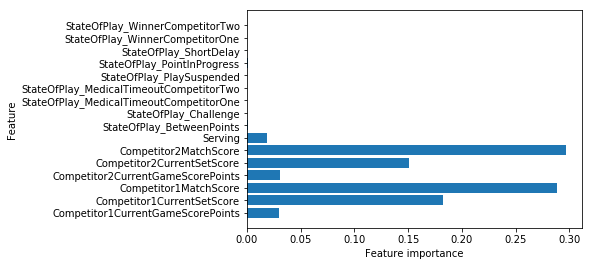

In [125]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances(DTC)

#### Random Forest model

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [128]:
RFC = RandomForestClassifier()

In [129]:
RFC.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [130]:
print("Accuracy on training set: {:.3f}".format(RFC.score(X_train_scaled, y_train))) 
print("Accuracy on test set: {:.3f}".format(RFC.score(X_test_scaled, y_test)))

Accuracy on training set: 0.750
Accuracy on test set: 0.740


In [133]:
y_test_pred = RFC.predict(X_test_scaled)

In [134]:
confusion = confusion_matrix(y_test, y_test_pred)
pd.DataFrame(confusion, columns=['predicted loss', 'predicted win'], index=['true loss', 'true win'])

,predicted loss,predicted win
true loss,62792,25164
true win,22369,72790


In [135]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.74      0.71      0.73     87956
          1       0.74      0.76      0.75     95159

avg / total       0.74      0.74      0.74    183115



In [142]:
RFC.predict_proba(X_test_scaled)[:4]

array([[ 0.76269154,  0.23730846],
       [ 1.        ,  0.        ],
       [ 0.98409379,  0.01590621],
       [ 0.37877249,  0.62122751]])

In [137]:
y_test_proba = RFC.predict_proba(X_test_scaled)

In [138]:
y_test_proba[:,1][:3]

array([ 0.23730846,  0.        ,  0.01590621])

In [139]:
fpr, tpr, thresh = roc_curve(y_test, y_test_proba[:,1])

In [140]:
auc(fpr,tpr)

0.82772217789890101

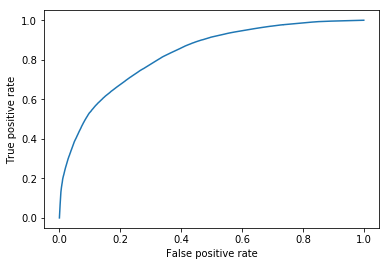

In [141]:
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

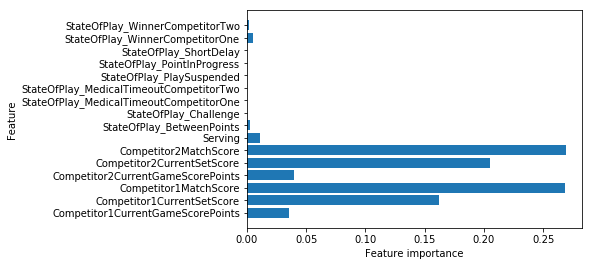

In [143]:
plot_feature_importances(RFC)